## Managing Imports

In [19]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler


## Initialising Dataset + Extra Processing 
Nothing too difficult here. Just for notice, scope tuning (will store scope - 1 hours of data for prediction)

In [20]:
scope = 49

Working with data. You can see all featue selection here!

In [21]:
# Load data
data = pd.read_csv("Preprocessed_Solar_Power_Data_v3.csv")

# drop NA rows
data = data.dropna()

lagged_cols_demand = {f"lag_{lag}": data["TOTALDEMAND"].shift(lag) for lag in range(1, scope)}
lagged_df_demand = pd.DataFrame(lagged_cols_demand, index=data.index)
data_demand = pd.concat([data, lagged_df_demand], axis=1).dropna()

X1 = data_demand[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y1 = data_demand["TOTALDEMAND"]

lagged_cols_irr = {f"lag_{lag}": data["ALLSKY_SFC_SW_DWN"].shift(lag) for lag in range(1, scope)}
lagged_df_irr = pd.DataFrame(lagged_cols_irr, index=data.index)
data_irr = pd.concat([data, lagged_df_irr], axis=1).dropna()

X2 = data_irr[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y2 = data_irr["ALLSKY_SFC_SW_DWN"]


## Run this before any test!
Also, I will give a quick overview of all of the relevant graphs in case!

In [22]:
def metrics(y, X, pipeline):
    tscv = TimeSeriesSplit(n_splits=12)

    # Reset inside the function
    train_metrics = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    test_metrics  = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred  = pipeline.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_test_pred)

        train_metrics['MSE'].append(mse_train)
        train_metrics['MAE'].append(mae_train)
        train_metrics['RMSE'].append(rmse_train)
        train_metrics['R2'].append(r2_train)

        test_metrics['MSE'].append(mse_test)
        test_metrics['MAE'].append(mae_test)
        test_metrics['RMSE'].append(rmse_test)
        test_metrics['R2'].append(r2_test)

        print(f"Fold {fold+1}:")
        print(f"Train -> MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")
        print(f"Test  -> MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}")
        print("______________")

    print("Average Training Metrics:")
    print({k: sum(v)/len(v) for k, v in train_metrics.items()})
    print("Average Testing Metrics:")
    print({k: sum(v)/len(v) for k, v in test_metrics.items()})

    residuals = y_test - y_test_pred

    spearman = stats.spearmanr(y_test, y_test_pred).correlation
    kendall = stats.kendalltau(y_test, y_test_pred).correlation
    print(f"Spearman ρ: {spearman:.3f}, Kendall τ: {kendall:.3f}")

    y_shuffled = y_test.sample(frac=1.0, random_state=42)
    r2_shuffled = r2_score(y_shuffled, y_test_pred)
    print(f"R² shuffled: {r2_shuffled:.3f}") 
    
    # Residual vs Predicted
    sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.show()

    # Distribution of residuals
    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residual Distribution")
    plt.show()

    # Q-Q Plot (normality check)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Select only numeric columns
    numeric_X = X.select_dtypes(include=['float64', 'int64'])

    # Correlation between each feature and the true target
    corr_with_target = numeric_X.corrwith(y).sort_values(ascending=False)
    plt.figure(figsize=(6,8))
    sns.barplot(x=corr_with_target, y=corr_with_target.index, orient='h')
    plt.title("Feature Correlation with Target (y)")
    plt.xlabel("Correlation Coefficient (Pearson)")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_test_pred, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted Demand (Last Fold)")
    plt.show()

    corrs = X[[col for col in X.columns if col.startswith("lag_")]].corrwith(y)
    plt.plot(range(1, len(corrs) + 1), corrs)
    plt.title("Lag Correlation with Target")
    plt.show()    
    
    plt.plot(residuals)
    plt.title("Residuals over Time")
    plt.show()

    return pipeline




In [29]:
def metrics_no_training(y, X, pipeline):
    tscv = TimeSeriesSplit(n_splits=12)

    # Reset inside the function
    train_metrics = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    test_metrics  = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred  = pipeline.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_test_pred)

        train_metrics['MSE'].append(mse_train)
        train_metrics['MAE'].append(mae_train)
        train_metrics['RMSE'].append(rmse_train)
        train_metrics['R2'].append(r2_train)

        test_metrics['MSE'].append(mse_test)
        test_metrics['MAE'].append(mae_test)
        test_metrics['RMSE'].append(rmse_test)
        test_metrics['R2'].append(r2_test)

        print(f"Fold {fold+1}:")
        print(f"Train -> MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")
        print(f"Test  -> MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}")
        print("______________")

    print("Average Training Metrics:")
    print({k: sum(v)/len(v) for k, v in train_metrics.items()})
    print("Average Testing Metrics:")
    print({k: sum(v)/len(v) for k, v in test_metrics.items()})

    residuals = y_test - y_test_pred

    spearman = stats.spearmanr(y_test, y_test_pred).correlation
    kendall = stats.kendalltau(y_test, y_test_pred).correlation
    print(f"Spearman ρ: {spearman:.3f}, Kendall τ: {kendall:.3f}")

    y_shuffled = y_test.sample(frac=1.0, random_state=42)
    r2_shuffled = r2_score(y_shuffled, y_test_pred)
    print(f"R² shuffled: {r2_shuffled:.3f}") 
    
    # Residual vs Predicted
    sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.show()

    # Distribution of residuals
    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residual Distribution")
    plt.show()

    # Q-Q Plot (normality check)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Select only numeric columns
    numeric_X = X.select_dtypes(include=['float64', 'int64'])

    # Correlation between each feature and the true target
    corr_with_target = numeric_X.corrwith(y).sort_values(ascending=False)
    plt.figure(figsize=(6,8))
    sns.barplot(x=corr_with_target, y=corr_with_target.index, orient='h')
    plt.title("Feature Correlation with Target (y)")
    plt.xlabel("Correlation Coefficient (Pearson)")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_test_pred, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted Demand (Last Fold)")
    plt.show()

    corrs = X[[col for col in X.columns if col.startswith("lag_")]].corrwith(y)
    plt.plot(range(1, len(corrs) + 1), corrs)
    plt.title("Lag Correlation with Target")
    plt.show()    
    
    plt.plot(residuals)
    plt.title("Residuals over Time")
    plt.show()

    return pipeline


## Initialising MLP Pipeline
Run this code to get MLP training (needs to run once to initialise everything)

In [23]:
Solar_Pipeline = None
Demand_Pipeline = None
test = None

def setMLP():
    global Solar_Pipeline, Demand_Pipeline, test

    Solar_Regressor = MLPRegressor(
        hidden_layer_sizes=(50,50),
        max_iter=4000,
        activation='relu',
        solver='adam',
        learning_rate_init=0.006247564316322379,
        learning_rate='adaptive',
        alpha=0.0007174815096277166,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Solar_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('mlp', Solar_Regressor)
    ])

    Demand_Regressor = MLPRegressor(
        hidden_layer_sizes=(20,20,20,15),
        max_iter=4000,
        activation='relu',        
        solver='adam',
        learning_rate_init=0.004253303307632643, 
        learning_rate='adaptive',
        alpha=00.0006208342600258237,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Demand_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('mlp', Demand_Regressor)
    ])

    return Solar_Pipeline, Demand_Pipeline, "MLP"

def setWNN():
    global Solar_Pipeline, test

    n_neighbors = 10
    weights = "distance"
    algorithm = "auto"
    metric = "minkowski"
    p = 2
    leaf_size = 30
    n_jobs = None
    metric_params = None

    # Use the same feature selection and PCA settings from your earlier code
    k_select = 50           # adjust if you use different feature count logic
    pca_components = 20     # adjust if needed
    random_state = 42

    Solar_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("knn", KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            p=p
        )),
    ])

    return Solar_Pipeline, Solar_Pipeline, "WNN"

def setRF():
    global Solar_Pipeline, Demand_Pipeline, test

    # --- Parameters ---
    n_estimators_solar = 50
    n_estimators_demand = 100
    random_state = 42
    k_select = 50
    pca_components = 20

    # --- Regressors ---
    Solar_Regressor = RandomForestRegressor(
        n_estimators=n_estimators_solar,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="log2",
        bootstrap=True,
        random_state=random_state
    )

    Demand_Regressor = RandomForestRegressor(
        n_estimators=n_estimators_demand,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features="sqrt",
        bootstrap=True,
        random_state=random_state
    )

    # --- Pipelines ---
    Solar_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("rf", Solar_Regressor)
    ])

    Demand_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("rf", Demand_Regressor)
    ])

    return Solar_Pipeline, Demand_Pipeline, "RF"


def setModel(model):
    global Solar_Pipeline, Demand_Pipeline, test
    if model == "WNN":
        return setWNN()
    elif model == "MLP":
        return setMLP()
    elif model == "RF":
        return setRF()

    else:
        print("No model assigned.")

## Setting the Solar/Demand Pipelines
Run and modify model based on the model you want to obtain data for.

Training MLP Irradiance ML Model. Please wait...
Fold 1:
Train -> MSE: 18747.09, MAE: 101.79, RMSE: 136.92, R2: 0.99
Test  -> MSE: 132376.62, MAE: 246.56, RMSE: 363.84, R2: 0.91
______________
Fold 2:
Train -> MSE: 30855.18, MAE: 127.14, RMSE: 175.66, R2: 0.98
Test  -> MSE: 63133.04, MAE: 193.13, RMSE: 251.26, R2: 0.97
______________
Fold 3:
Train -> MSE: 23724.28, MAE: 109.54, RMSE: 154.03, R2: 0.98
Test  -> MSE: 34649.21, MAE: 141.39, RMSE: 186.14, R2: 0.97
______________
Fold 4:
Train -> MSE: 21901.17, MAE: 101.59, RMSE: 147.99, R2: 0.99
Test  -> MSE: 31295.85, MAE: 131.18, RMSE: 176.91, R2: 0.98
______________
Fold 5:
Train -> MSE: 22837.24, MAE: 102.79, RMSE: 151.12, R2: 0.99
Test  -> MSE: 37455.88, MAE: 148.12, RMSE: 193.54, R2: 0.97
______________
Fold 6:
Train -> MSE: 17640.64, MAE: 92.86, RMSE: 132.82, R2: 0.99
Test  -> MSE: 26582.12, MAE: 127.33, RMSE: 163.04, R2: 0.98
______________
Fold 7:
Train -> MSE: 20777.22, MAE: 99.85, RMSE: 144.14, R2: 0.99
Test  -> MSE: 22735.66, MA

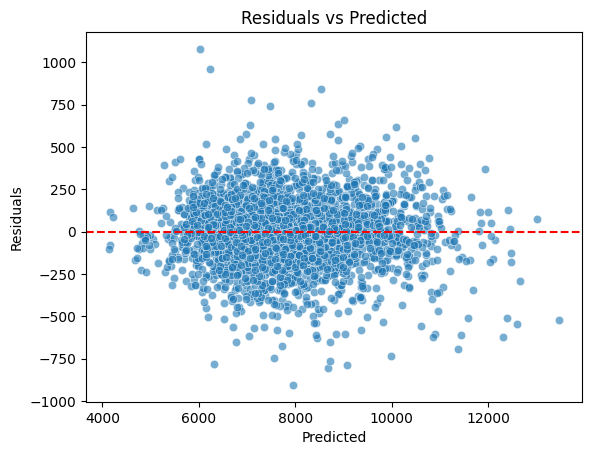

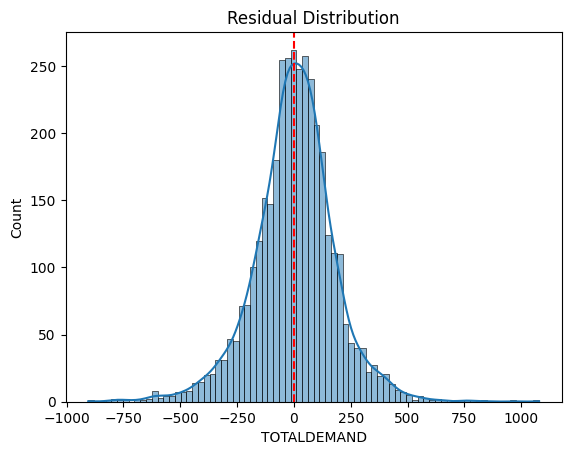

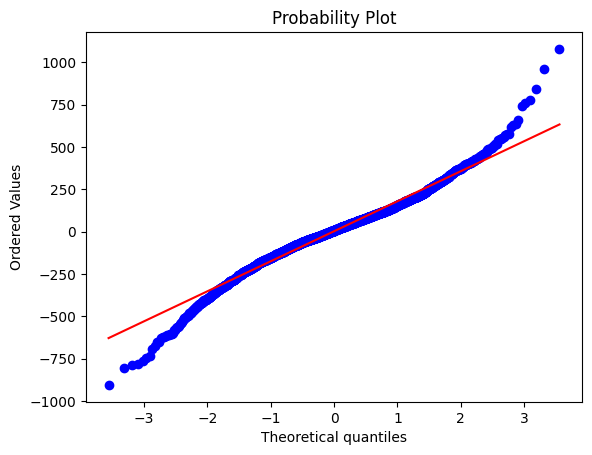

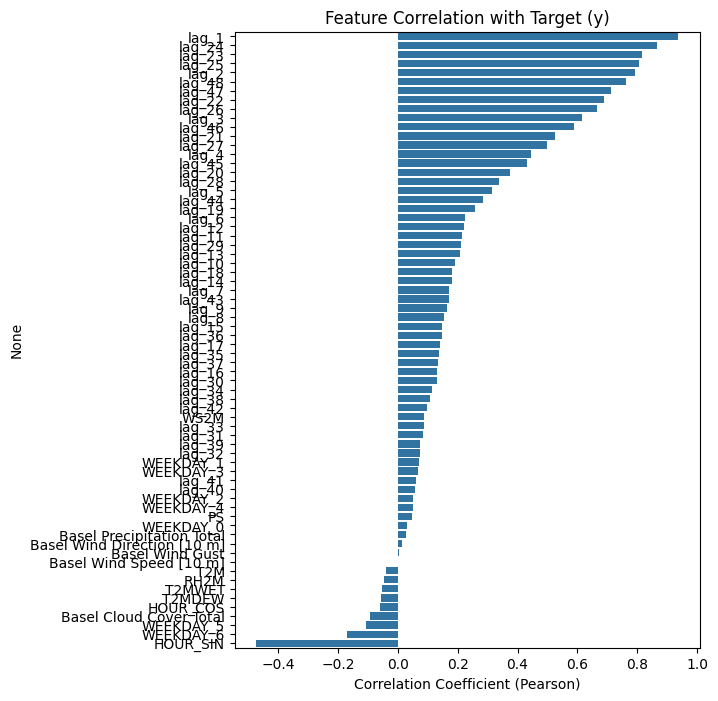

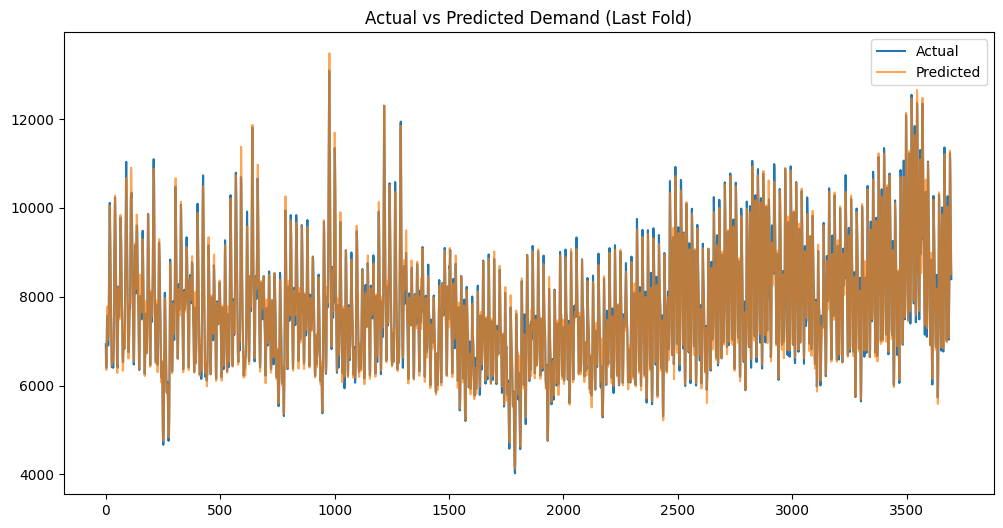

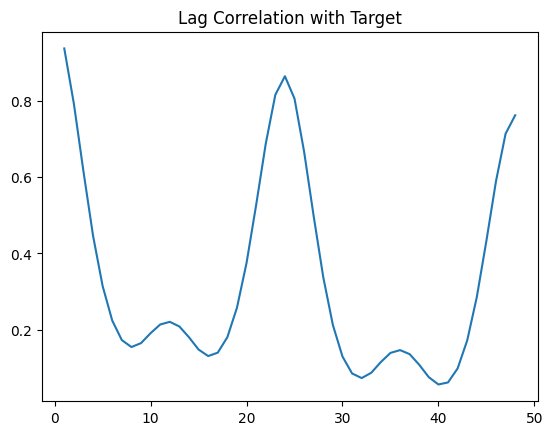

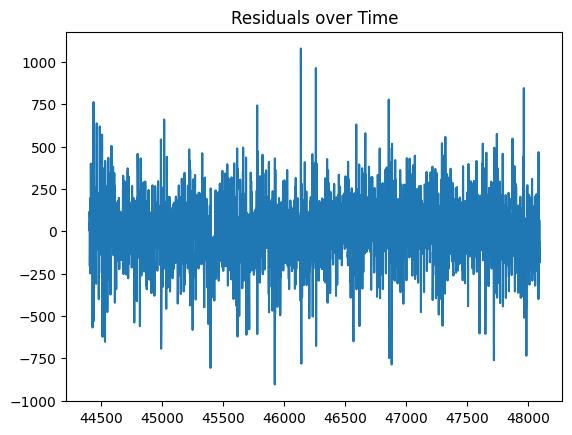

Training MLP Demand ML Model. Please wait...
Fold 1:
Train -> MSE: 742.70, MAE: 13.85, RMSE: 27.25, R2: 0.99
Test  -> MSE: 1070.11, MAE: 16.33, RMSE: 32.71, R2: 0.98
______________
Fold 2:
Train -> MSE: 687.72, MAE: 12.70, RMSE: 26.22, R2: 0.99
Test  -> MSE: 1767.83, MAE: 21.59, RMSE: 42.05, R2: 0.98
______________
Fold 3:
Train -> MSE: 933.49, MAE: 14.82, RMSE: 30.55, R2: 0.99
Test  -> MSE: 471.07, MAE: 10.39, RMSE: 21.70, R2: 0.99
______________
Fold 4:
Train -> MSE: 874.28, MAE: 13.73, RMSE: 29.57, R2: 0.99
Test  -> MSE: 1797.16, MAE: 21.17, RMSE: 42.39, R2: 0.98
______________
Fold 5:
Train -> MSE: 949.14, MAE: 13.97, RMSE: 30.81, R2: 0.99
Test  -> MSE: 822.72, MAE: 12.71, RMSE: 28.68, R2: 0.98
______________
Fold 6:
Train -> MSE: 969.25, MAE: 14.27, RMSE: 31.13, R2: 0.99
Test  -> MSE: 1255.65, MAE: 16.55, RMSE: 35.44, R2: 0.98
______________
Fold 7:
Train -> MSE: 969.69, MAE: 14.33, RMSE: 31.14, R2: 0.99
Test  -> MSE: 1212.12, MAE: 16.79, RMSE: 34.82, R2: 0.98
______________
Fold 

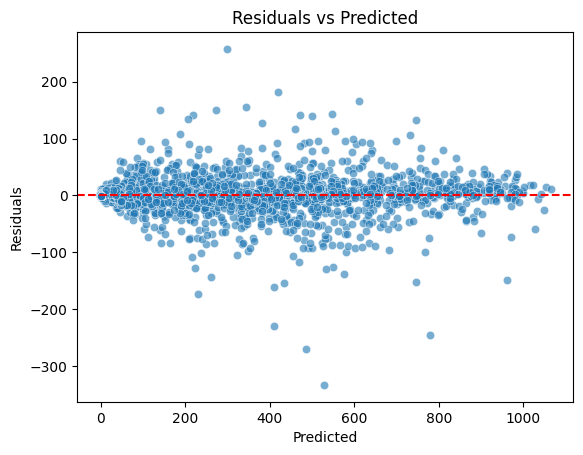

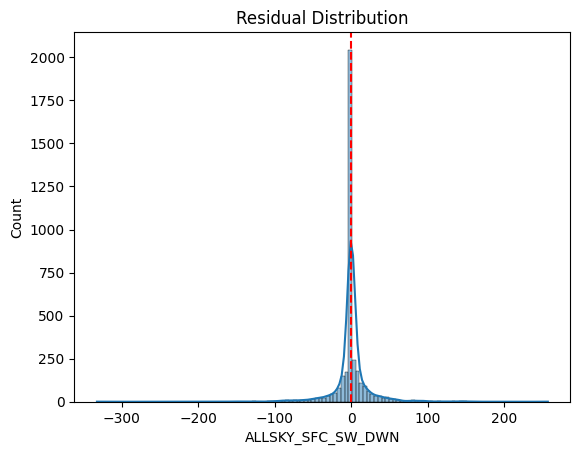

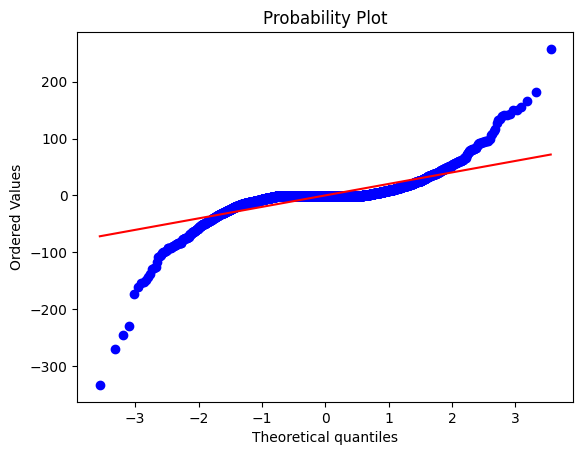

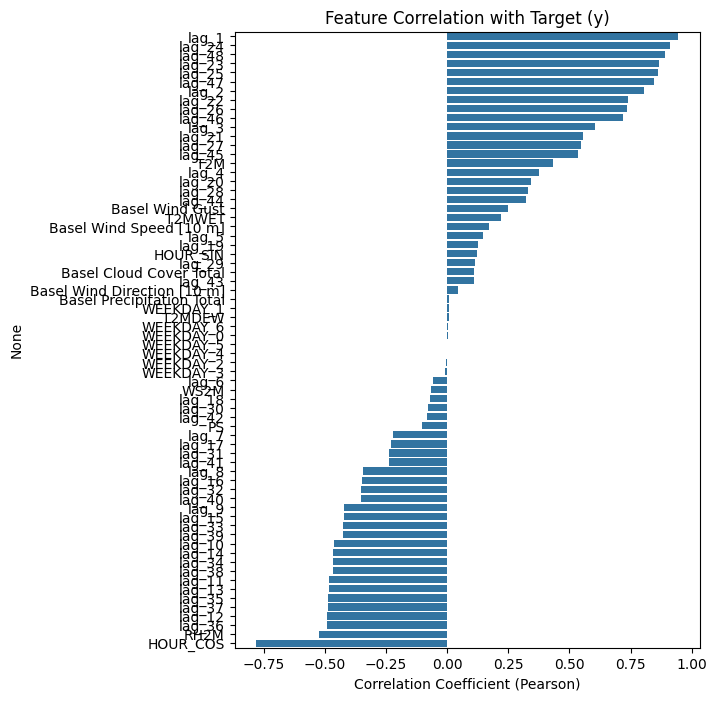

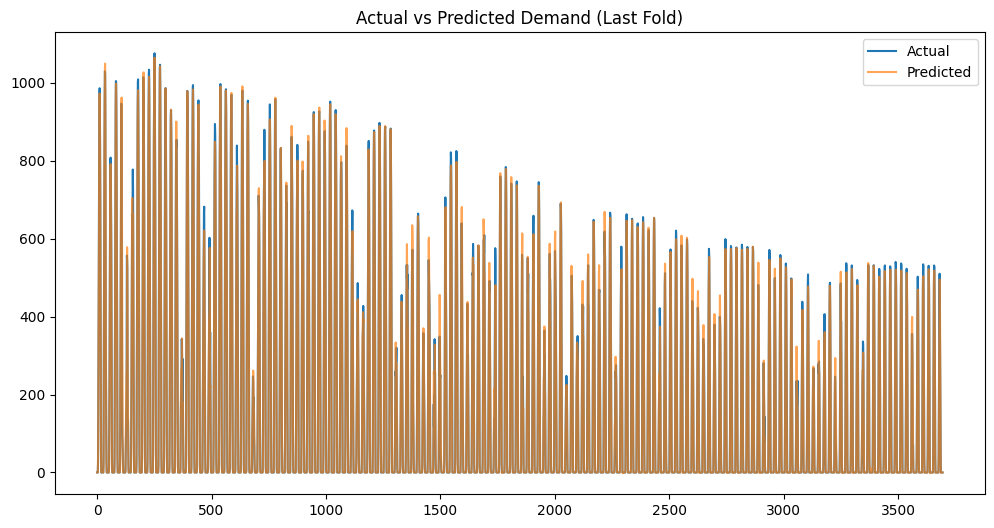

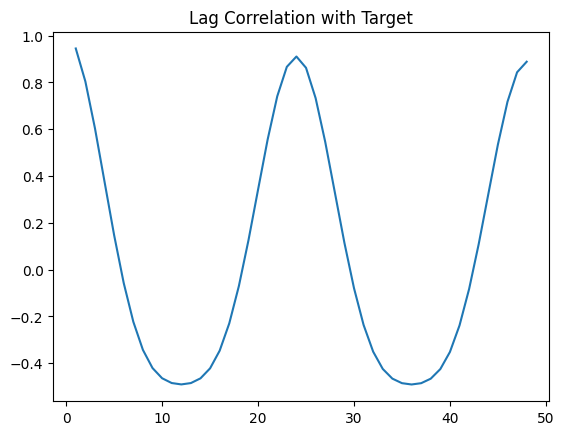

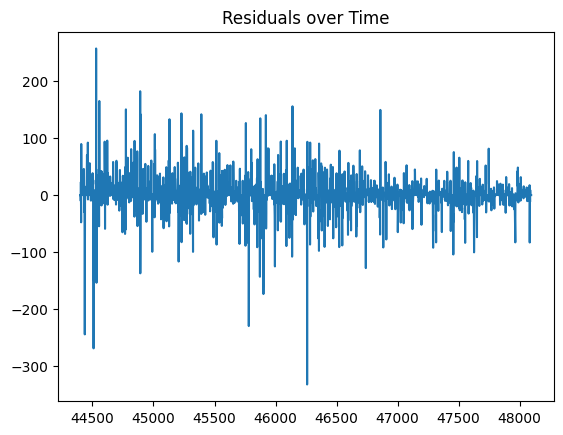

In [31]:
# Choose between "WNN", "RF", "MLP"
model = "MLP"
Solar_Pipeline, Demand_Pipeline, test = setModel(model)
print(f"Training {test} Irradiance ML Model. Please wait...")
solarModel = metrics(y1, X1, Solar_Pipeline)
print(f"Training {test} Demand ML Model. Please wait...")
demandModel = metrics(y2, X2, Demand_Pipeline)




## Creating new dataset (uses 2024-2025)
Run once before saving the csv!

In [25]:
# Load data
df = pd.read_csv("Preprocessed_Solar_Power_Data_24-25_v1.csv")


# drop NA rows
df = df.dropna()

lagged_cols_demand = {f"lag_{lag}": df["TOTALDEMAND"].shift(lag) for lag in range(1, scope)}
lagged_df_demand = pd.DataFrame(lagged_cols_demand, index=data.index)
data_demand = pd.concat([df, lagged_df_demand], axis=1).dropna()

X1_ = data_demand[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y1_ = data_demand["TOTALDEMAND"]

lagged_cols_irr = {f"lag_{lag}": data["ALLSKY_SFC_SW_DWN"].shift(lag) for lag in range(1, scope)}
lagged_df_irr = pd.DataFrame(lagged_cols_irr, index=data.index)
data_irr = pd.concat([data, lagged_df_irr], axis=1).dropna()

X2_ = data_irr[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y2_ = data_irr["ALLSKY_SFC_SW_DWN"]




Training on new dataset, make sure that old model is currently trained!


Evaluating MLP Irradiance Model on New Dataset...
Fold 1:
Train -> MSE: 9040960.48, MAE: 2947.67, RMSE: 3006.82, R2: -111.80
Test  -> MSE: 9130711.72, MAE: 2961.52, RMSE: 3021.71, R2: -157.14
______________
Fold 2:
Train -> MSE: 9085836.10, MAE: 2954.59, RMSE: 3014.27, R2: -130.03
Test  -> MSE: 8964939.12, MAE: 2932.45, RMSE: 2994.15, R2: -82.97
______________
Fold 3:
Train -> MSE: 9045537.11, MAE: 2947.21, RMSE: 3007.58, R2: -108.14
Test  -> MSE: 9101020.12, MAE: 2958.19, RMSE: 3016.79, R2: -211.41
______________
Fold 4:
Train -> MSE: 9059407.86, MAE: 2949.96, RMSE: 3009.89, R2: -121.82
Test  -> MSE: 8849528.33, MAE: 2911.34, RMSE: 2974.82, R2: -81.85
______________
Fold 5:
Train -> MSE: 9017431.95, MAE: 2942.23, RMSE: 3002.90, R2: -110.24
Test  -> MSE: 9111818.56, MAE: 2960.63, RMSE: 3018.58, R2: -182.18
______________
Fold 6:
Train -> MSE: 9033163.05, MAE: 2945.30, RMSE: 3005.52, R2: -117.45
Test  -> MSE: 8973678.85, MAE: 2932.43, RMSE: 2995.61, R2: -106.62
______________
Fold 7:
T

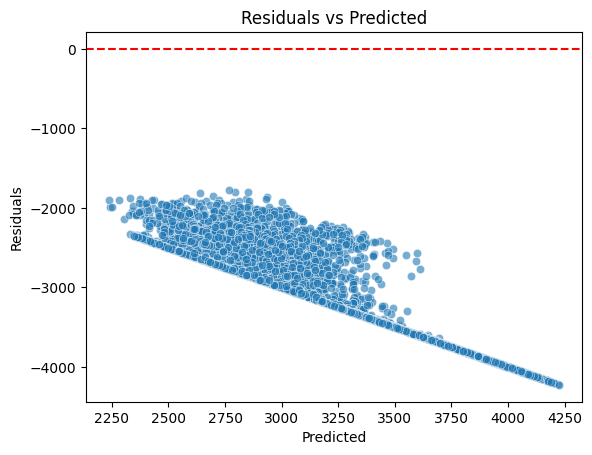

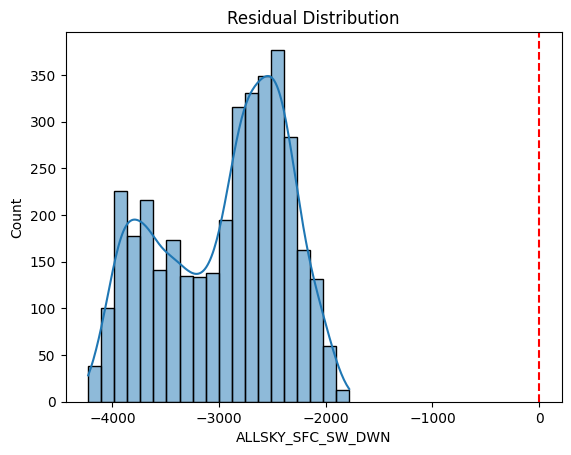

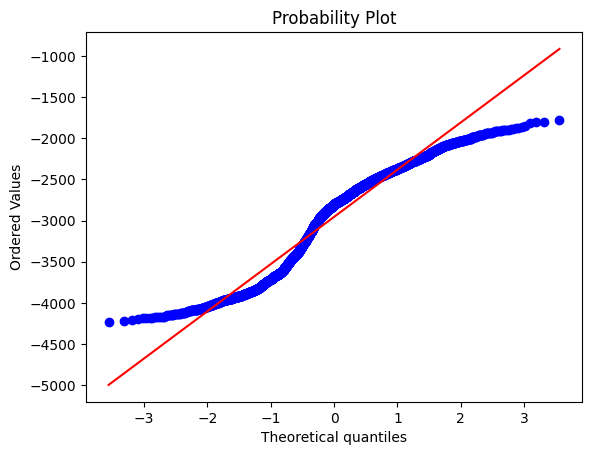

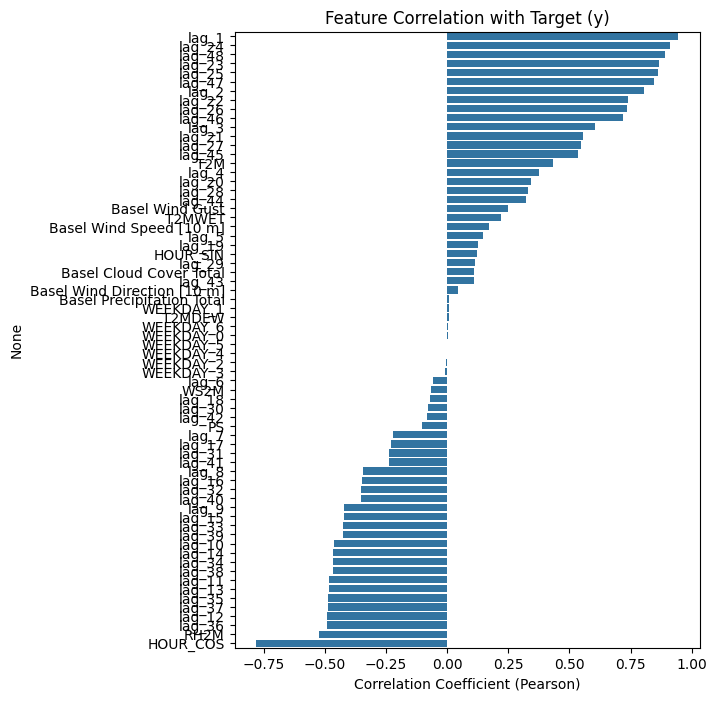

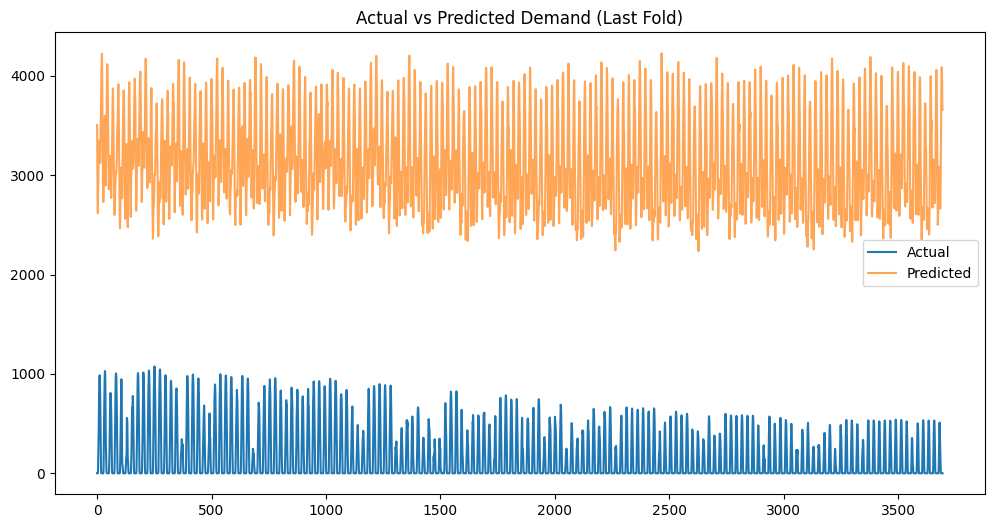

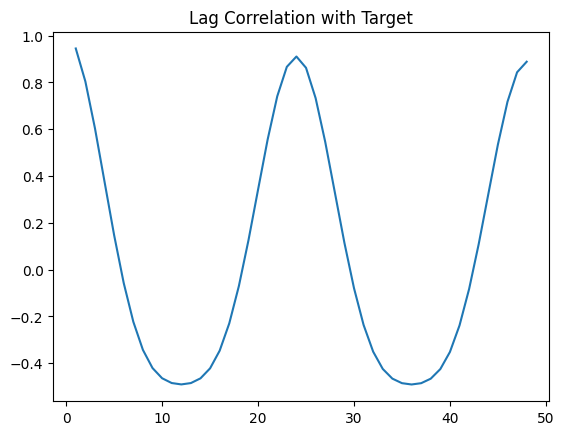

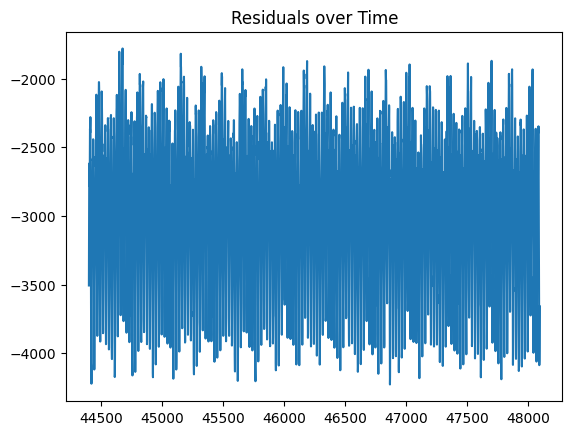


Evaluating MLP Demand Model on New Dataset...
Fold 1:
Train -> MSE: 35879454.53, MAE: 5954.64, RMSE: 5989.95, R2: -17.21
Test  -> MSE: 35127328.31, MAE: 5893.13, RMSE: 5926.83, R2: -16.70
______________
Fold 2:
Train -> MSE: 35503951.87, MAE: 5923.93, RMSE: 5958.52, R2: -16.92
Test  -> MSE: 31512662.09, MAE: 5563.47, RMSE: 5613.61, R2: -13.64
______________
Fold 3:
Train -> MSE: 34174844.44, MAE: 5803.90, RMSE: 5845.93, R2: -15.24
Test  -> MSE: 20929828.66, MAE: 4540.17, RMSE: 4574.91, R2: -10.19
______________
Fold 4:
Train -> MSE: 30866059.74, MAE: 5488.20, RMSE: 5555.72, R2: -10.59
Test  -> MSE: 21077684.80, MAE: 4552.72, RMSE: 4591.04, R2: -13.55
______________
Fold 5:
Train -> MSE: 28909552.81, MAE: 5301.22, RMSE: 5376.76, R2: -9.70
Test  -> MSE: 20548271.22, MAE: 4500.00, RMSE: 4533.02, R2: -14.69
______________
Fold 6:
Train -> MSE: 27516698.84, MAE: 5167.75, RMSE: 5245.64, R2: -9.41
Test  -> MSE: 26075960.30, MAE: 5072.37, RMSE: 5106.46, R2: -13.71
______________
Fold 7:
Train

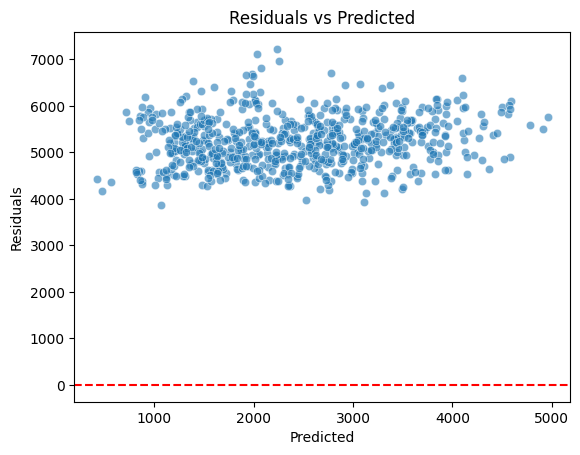

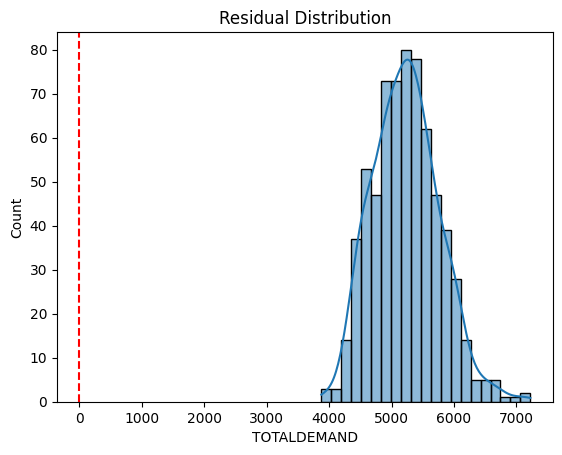

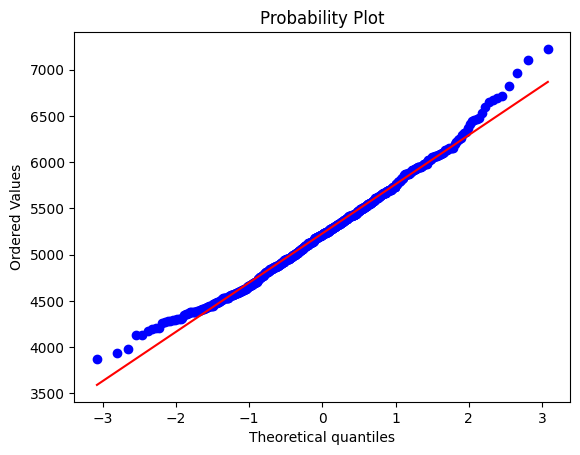

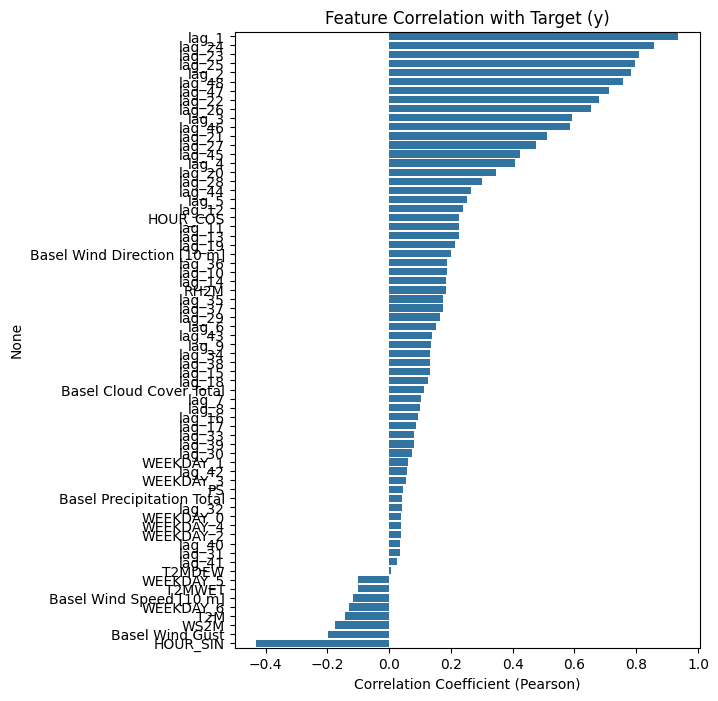

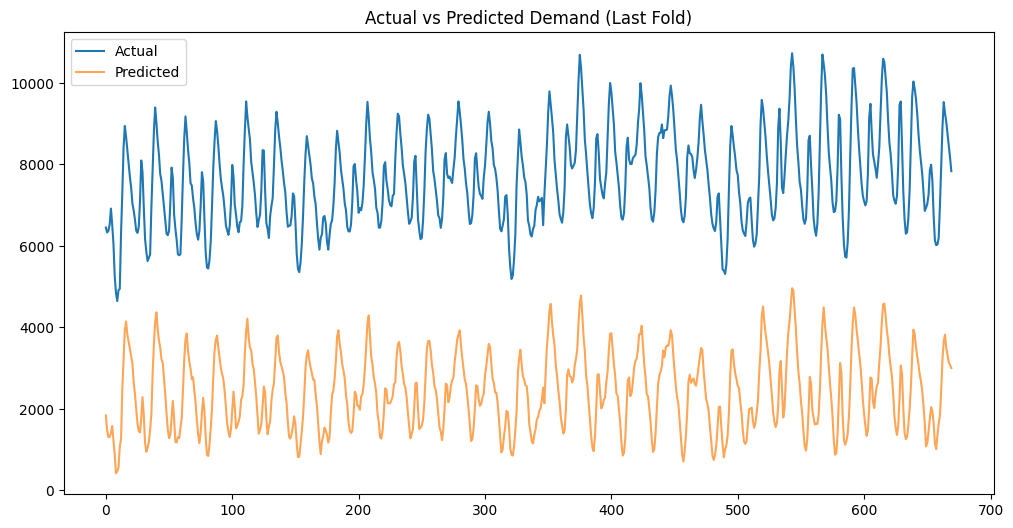

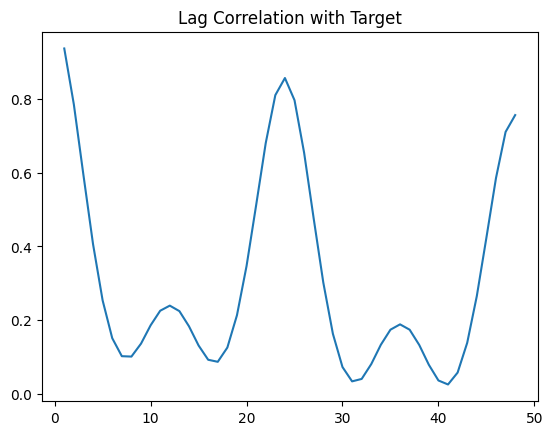

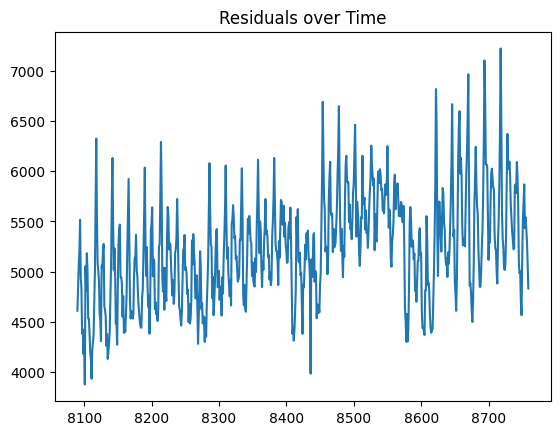

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [32]:
# train_cols = list(X1.columns)
# new_cols = list(X1_.columns)

# missing = [c for c in train_cols if c not in new_cols]
# extra   = [c for c in new_cols if c not in train_cols]

# for col in X1.columns:
#     print(col, X1[col].mean(), X1_[col].mean())


# print(X1.describe().loc[['min','max','mean']])
# print(X1_.describe().loc[['min','max','mean']])

# train_corr = X1.corrwith(y1)
# new_corr   = X1_.corrwith(y1_)

# diff = (train_corr - new_corr).abs().sort_values(ascending=False)
# print(diff.head(10))


# print("Missing columns:", missing)
# print("Extra columns:", extra)
# print("Same shape:", len(train_cols) == len(new_cols))


print(f"\nEvaluating {model} Irradiance Model on New Dataset...")
metrics_no_training(y2_, X2_, solarModel)

print(f"\nEvaluating {model} Demand Model on New Dataset...")
metrics_no_training(y1_, X1_, demandModel)

Training MLP Irradiance ML Model. Please wait...
Fold 1:
Train -> MSE: 189055.09, MAE: 346.70, RMSE: 434.80, R2: 0.90
Test  -> MSE: 927726.65, MAE: 761.88, RMSE: 963.19, R2: 0.53
______________
Fold 2:
Train -> MSE: 211913.35, MAE: 339.66, RMSE: 460.34, R2: 0.89
Test  -> MSE: 501874.16, MAE: 549.67, RMSE: 708.43, R2: 0.77
______________
Fold 3:
Train -> MSE: 47824.10, MAE: 166.04, RMSE: 218.69, R2: 0.98
Test  -> MSE: 1105387.46, MAE: 844.26, RMSE: 1051.37, R2: 0.41
______________
Fold 4:
Train -> MSE: 31393.94, MAE: 133.91, RMSE: 177.18, R2: 0.99
Test  -> MSE: 154385.06, MAE: 311.38, RMSE: 392.92, R2: 0.89
______________
Fold 5:
Train -> MSE: 36778.38, MAE: 146.55, RMSE: 191.78, R2: 0.99
Test  -> MSE: 188453.97, MAE: 315.66, RMSE: 434.11, R2: 0.86
______________
Fold 6:
Train -> MSE: 37270.01, MAE: 146.41, RMSE: 193.05, R2: 0.99
Test  -> MSE: 258592.33, MAE: 396.23, RMSE: 508.52, R2: 0.85
______________
Fold 7:
Train -> MSE: 32656.05, MAE: 134.38, RMSE: 180.71, R2: 0.99
Test  -> MSE: 1

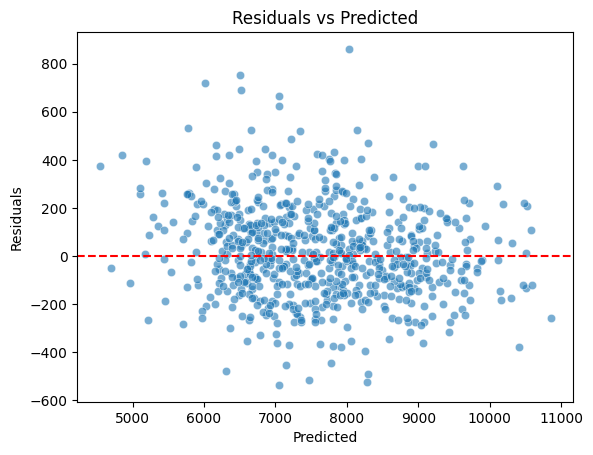

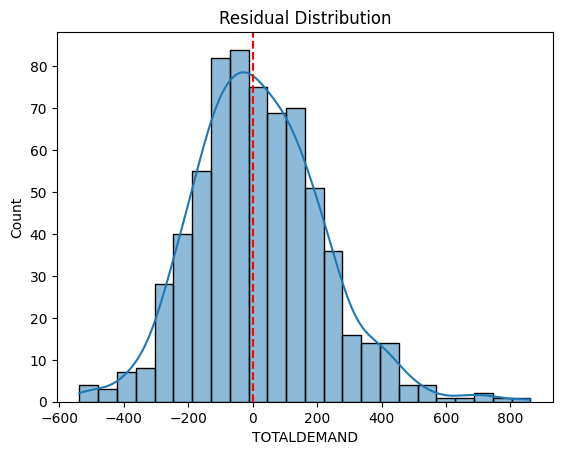

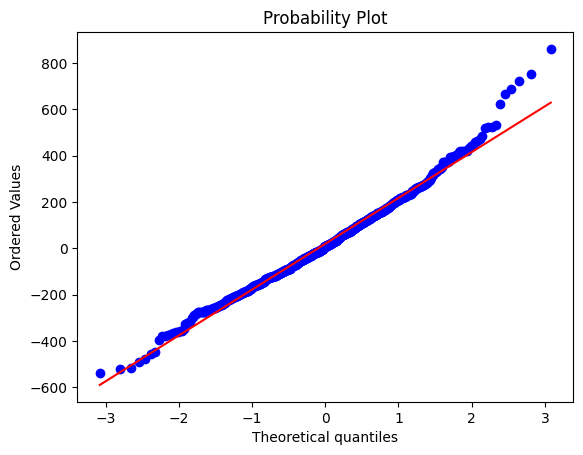

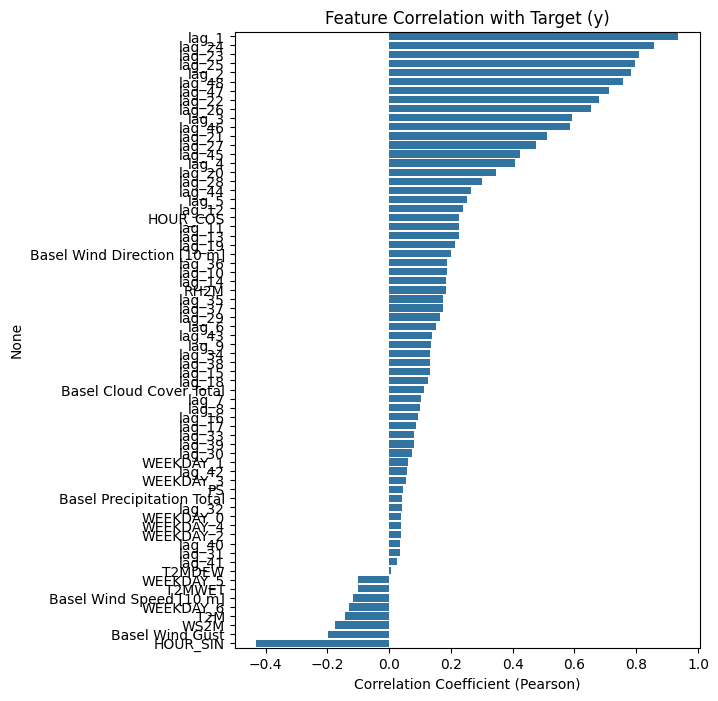

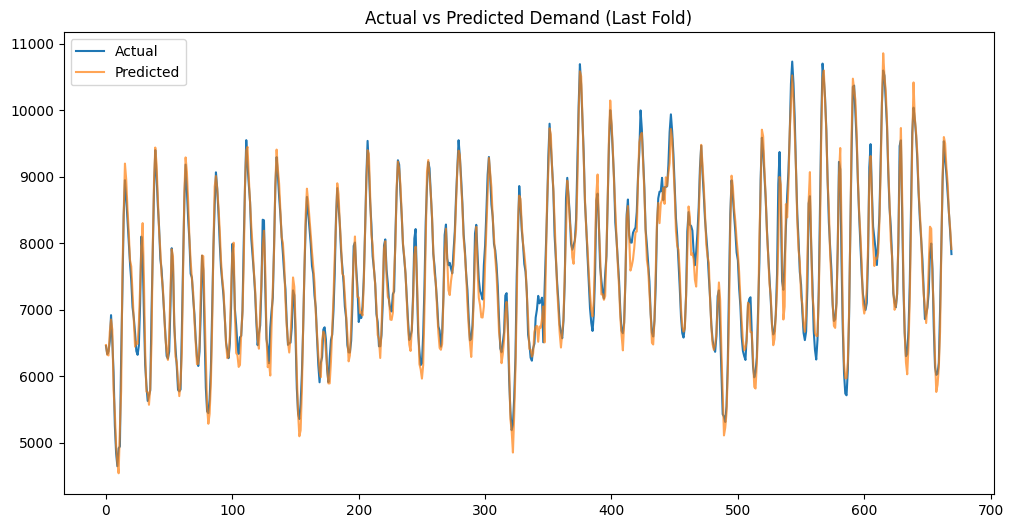

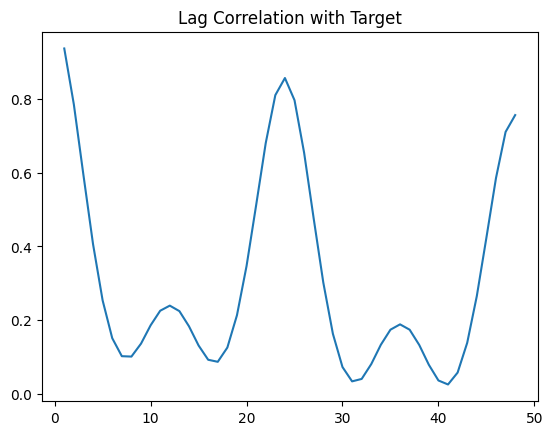

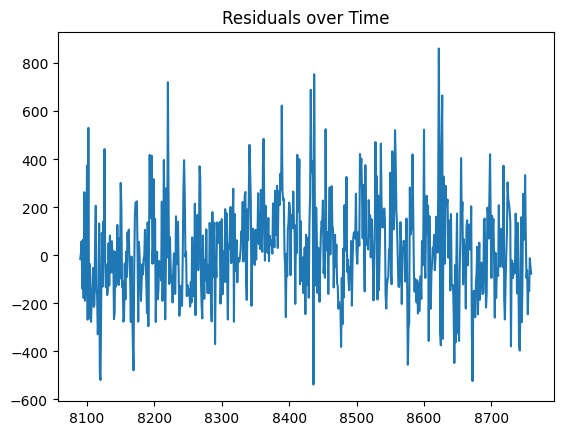

Training MLP Demand ML Model. Please wait...
Fold 1:
Train -> MSE: 742.70, MAE: 13.85, RMSE: 27.25, R2: 0.99
Test  -> MSE: 1070.11, MAE: 16.33, RMSE: 32.71, R2: 0.98
______________
Fold 2:
Train -> MSE: 687.72, MAE: 12.70, RMSE: 26.22, R2: 0.99
Test  -> MSE: 1767.83, MAE: 21.59, RMSE: 42.05, R2: 0.98
______________
Fold 3:
Train -> MSE: 933.49, MAE: 14.82, RMSE: 30.55, R2: 0.99
Test  -> MSE: 471.07, MAE: 10.39, RMSE: 21.70, R2: 0.99
______________
Fold 4:
Train -> MSE: 874.28, MAE: 13.73, RMSE: 29.57, R2: 0.99
Test  -> MSE: 1797.16, MAE: 21.17, RMSE: 42.39, R2: 0.98
______________
Fold 5:
Train -> MSE: 949.14, MAE: 13.97, RMSE: 30.81, R2: 0.99
Test  -> MSE: 822.72, MAE: 12.71, RMSE: 28.68, R2: 0.98
______________
Fold 6:
Train -> MSE: 969.25, MAE: 14.27, RMSE: 31.13, R2: 0.99
Test  -> MSE: 1255.65, MAE: 16.55, RMSE: 35.44, R2: 0.98
______________
Fold 7:
Train -> MSE: 969.69, MAE: 14.33, RMSE: 31.14, R2: 0.99
Test  -> MSE: 1212.12, MAE: 16.79, RMSE: 34.82, R2: 0.98
______________
Fold 

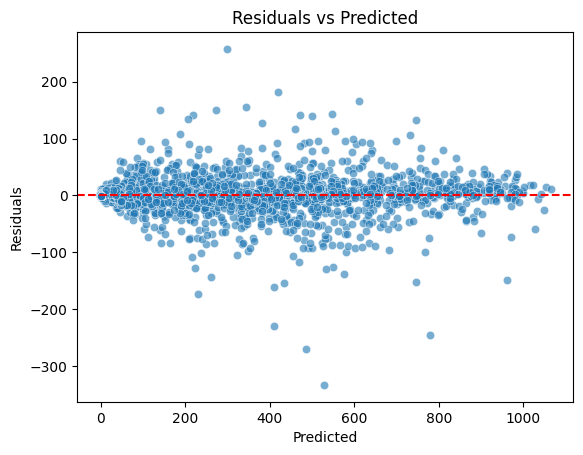

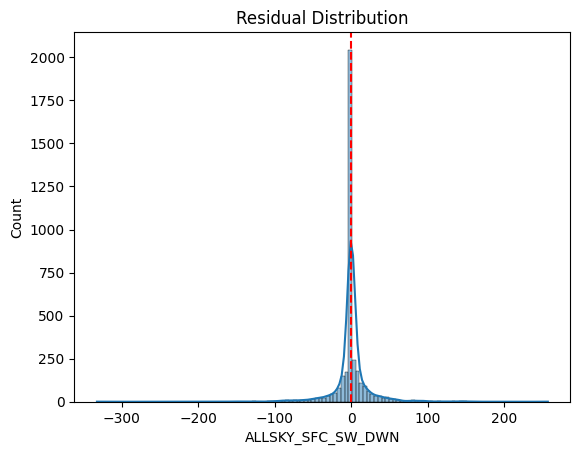

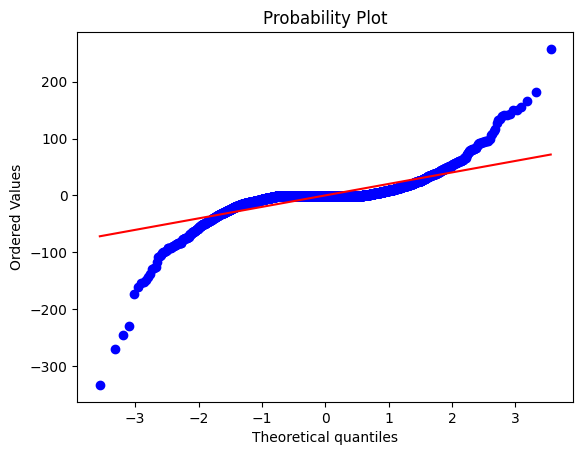

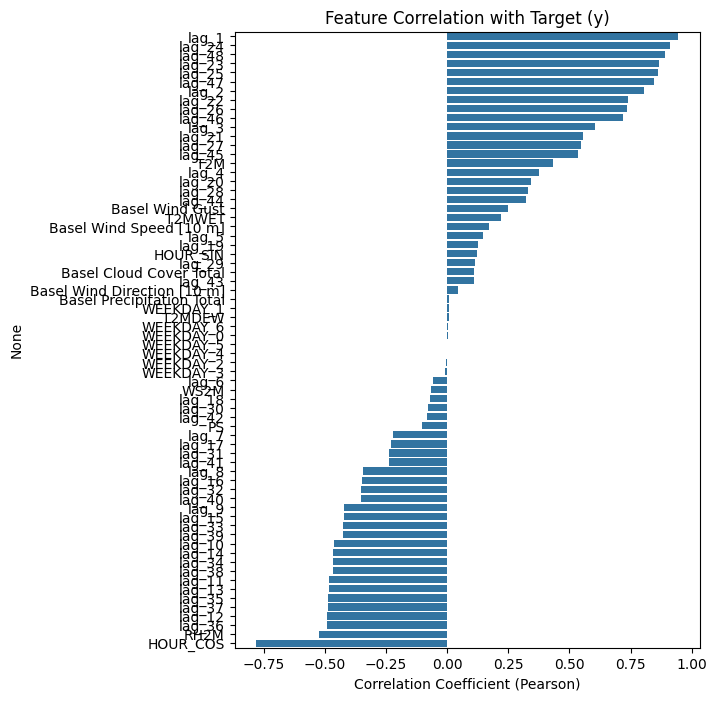

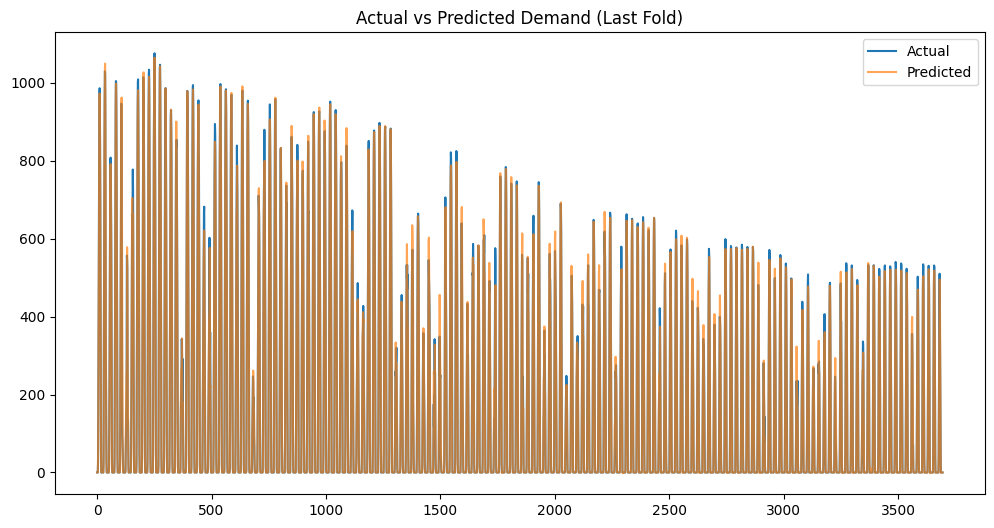

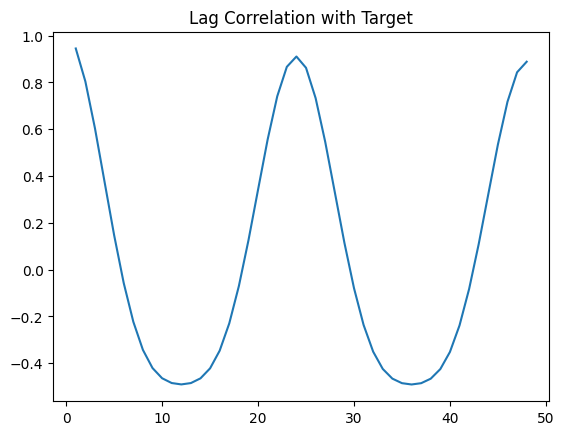

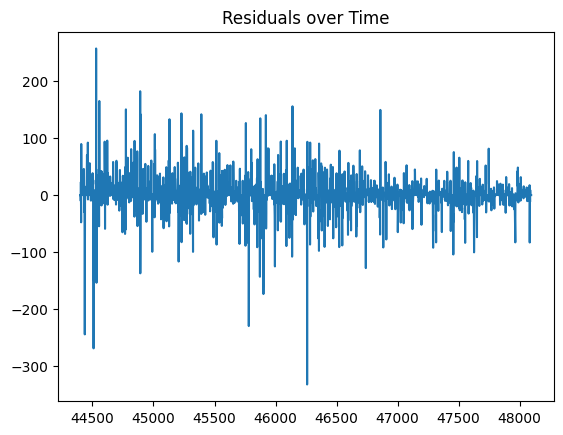

In [33]:
# Choose between "WNN", "RF", "MLP"
model = "MLP"
Solar_Pipeline, Demand_Pipeline, test = setModel(model)
print(f"Training {test} Irradiance ML Model. Please wait...")
solarModel = metrics(y1_, X1_, Solar_Pipeline)
print(f"Training {test} Demand ML Model. Please wait...")
demandModel = metrics(y2_, X2_, Demand_Pipeline)